In [8]:
import sys
import os
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join("..", "src")))

df = pd.read_csv('../Data/Processed/hotel_clean2.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29545 entries, 0 to 29544
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          29545 non-null  int64  
 1   no_of_children                        29545 non-null  int64  
 2   no_of_weekend_nights                  29545 non-null  int64  
 3   no_of_week_nights                     29545 non-null  int64  
 4   required_car_parking_space            29545 non-null  int64  
 5   lead_time                             29545 non-null  int64  
 6   arrival_year                          29545 non-null  int64  
 7   arrival_month                         29545 non-null  int64  
 8   arrival_date                          29545 non-null  int64  
 9   repeated_guest                        29545 non-null  int64  
 10  no_of_previous_cancellations          29545 non-null  int64  
 11  no_of_previous_

In [9]:

from sklearn.model_selection import train_test_split

# critères de base
x = df[['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space',
        'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
        'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan_Meal Plan 1',
        'type_of_meal_plan_Meal Plan 2', 'type_of_meal_plan_Meal Plan 3', 'type_of_meal_plan_Not Selected',
        'room_type_reserved_Room_Type 1', 'room_type_reserved_Room_Type 2', 'room_type_reserved_Room_Type 3',
        'room_type_reserved_Room_Type 4', 'room_type_reserved_Room_Type 5', 'room_type_reserved_Room_Type 6',
        'room_type_reserved_Room_Type 7', 'market_segment_type_Aviation', 'market_segment_type_Complementary',
        'market_segment_type_Corporate', 'market_segment_type_Offline', 'market_segment_type_Online']]

top_features = ['lead_time', 'no_of_special_requests', 'avg_price_per_room',
                'required_car_parking_space', 'type_of_meal_plan_Meal Plan 1',
                'market_segment_type_Online', 'no_of_week_nights', 'no_of_weekend_nights', 'no_of_previous_cancellations', 'room_type_reserved_Room_Type 1', 'repeated_guest']
x = df[top_features]
# Critère à prédire
y = df['booking_status_Not_Canceled']


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres : {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'log2', 'max_depth': None}
Accuracy sur les données de test :  0.88
Score moyen par validation croisée :  0.88
Précision :  0.89
Rappel :  0.94
Erreur quadratique moyenne :  0.1164
Accuracy (via accuracy_score) :  0.8836
Matrice de confusion :
 [[1560  454]
 [ 234 3661]]


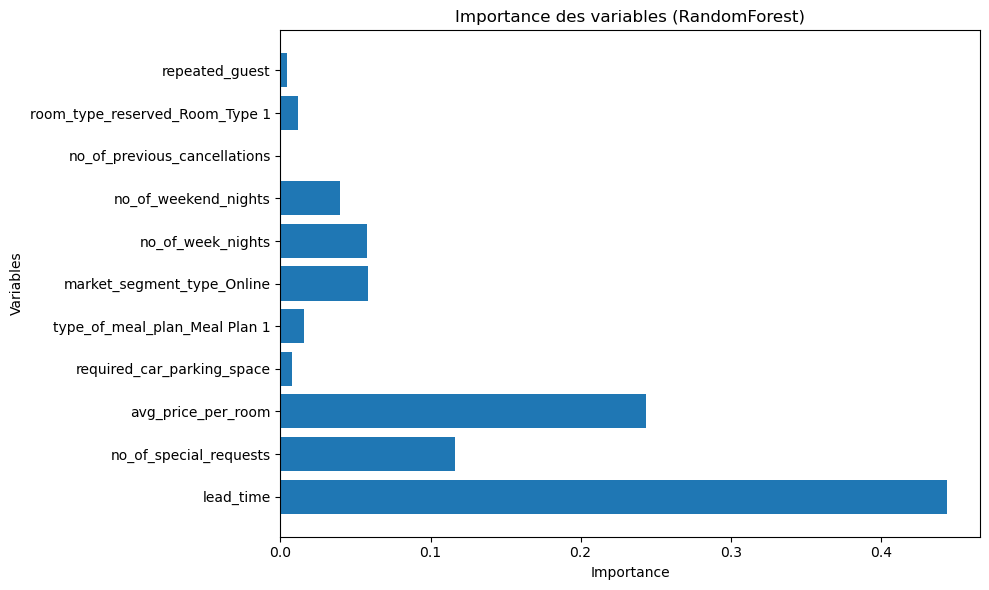

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1. Définir la grille d'hyperparamètres
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# 2. Création du modèle de base
rf = RandomForestClassifier(random_state=42)

# 3. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Entraînement
random_search.fit(x_train, y_train)

# 5. Meilleur modèle
best_rf = random_search.best_estimator_
print("Meilleurs hyperparamètres :", random_search.best_params_)

# 6. Prédictions
y_probs = best_rf.predict_proba(x_test)[:, 1]
y_pred_thresh = (y_probs >= 0.6).astype(int)  # Seuillage optionnel
y_pred = best_rf.predict(x_test)

# 7. Évaluation
print("Accuracy sur les données de test : ", np.round(best_rf.score(x_test, y_test), 2)) # 0.88
print("Score moyen par validation croisée : ",
      np.round(np.mean(cross_val_score(best_rf, x, y, cv=5)), 2)) # 0.88
print("Précision : ", np.round(precision_score(y_test, y_pred), 2)) # 0.89
print("Rappel : ", np.round(recall_score(y_test, y_pred), 2)) # 0.94
print("Erreur quadratique moyenne : ", np.round(mean_squared_error(y_test, y_pred), 4)) # 0.1164
print("Accuracy (via accuracy_score) : ", np.round(accuracy_score(y_test, y_pred), 4)) # 0.8836

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :\n", cm)
#    [[1560  454]
#    [ 234 3661]]

# 9. Importance des variables
importances = best_rf.feature_importances_
features = x_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Importance des variables (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()
